In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from embedding import Embedding
from forward_kinematics import ForwardKinematic
from dynamical_system import DynamicalSystem

In [2]:
# DS parameters
config_dim = 3
K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)
config_attractor = np.array([0.6, 0.15, 0.4])

# Embedding parameters
x = np.array([[-0.5], [1.8], [0.]])

fk = ForwardKinematic(urdf_file='3_joints_arm.urdf')

e = Embedding(dimension=fk.model.nq, x=x[np.newaxis, :, :], fk=fk)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.02)

In [3]:
config_start = np.array([-0.4, 0.3, 0.])
initial_speed = np.array([0.1, -0.1, 0.])
q = config_start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,1000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')

average execution frequency : 958.4232 Hz


In [4]:
q1 = np.linspace(-np.pi/2, np.pi/2, 50)
q2 = q1.copy()
q3 = q1.copy()
gridX, gridY, gridZ = np.meshgrid(q1, q2, q3)
grid = np.column_stack((gridX.ravel(), gridY.ravel(), gridZ.ravel()))
print(grid.shape)

(125000, 3)


In [5]:
a = np.zeros((grid.shape[0], 4))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q)
    a[i] = np.array([q[0], q[1], q[2], p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 24291.43622979629


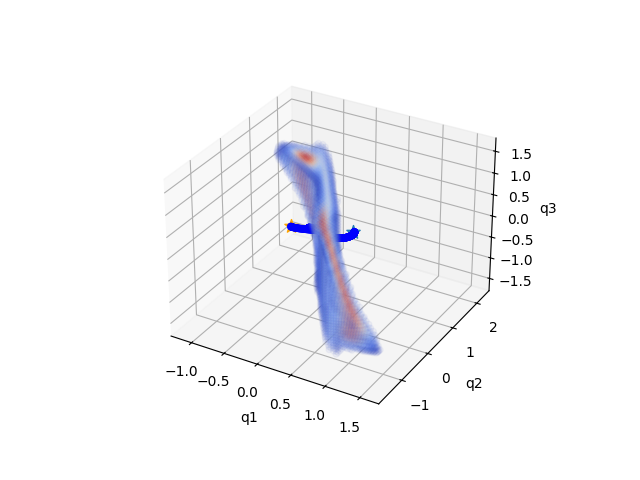

In [6]:
f = a[a[:, -1] > 2]
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
x3 = np.unique(a[:, 2])
z = a[:, -1].reshape((x1.shape[0], x2.shape[0], x3.shape[0]))

ps= np.stack(positions)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(f[:, 0], f[:, 1], f[:, 2], c=f[:, 3], cmap=cm.coolwarm, alpha=0.05)
ax.scatter(config_attractor[0], config_attractor[1], config_attractor[2], s=100, marker='*')
ax.scatter(config_start[0], config_start[1], config_start[2], s=100, marker='*', c='orange')
ax.scatter(ps[:, 0], ps[:,1], ps[:, 2], c='b')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('q3')
plt.show()

In [7]:
from itertools import combinations

def plot_coupled_embeddings(coordinates, attractor, streamlines, embedding, start):
    couples = list(combinations(np.linspace(0, coordinates.shape[1]-1, coordinates.shape[1]), r=2))
    fig, axs = plt.subplots(coordinates.shape[1], int(len(couples)/coordinates.shape[1]))
    fig.set_size_inches(7, 10)
    row = -1
    for b, couple in enumerate(couples):
        if axs.ndim == 1:
            ax = axs[b]
        else:
            ax = axs[row, b%axs.shape[1]]
        angle1, angle2 = int(couple[0]), int(couple[1])
        x = np.unique(embedding[:, angle1])
        y = np.unique(embedding[:, angle2])
        f = embedding[:, -1].reshape(tuple(x.shape[0] for _ in range(embedding.shape[1]-1)))
        dims_to_sum = tuple(map(lambda tup: tup[0], filter(lambda tup: tup[1], [(i, i not in (0, 1)) for i in range(3)])))
        z = f.sum(dims_to_sum) 
        ax.contourf(x, y, z, antialiased=False, alpha=0.35, cmap=cm.coolwarm)
        if attractor is not None:
            ax.scatter(attractor[angle1], attractor[angle2], marker='*', label='target', c='navy', s=40)
        if start is not None:
            ax.scatter(start[angle1], start[angle2], marker='*', label='start', c='gold', s=40)
        if streamlines is not None:
            ax.scatter(streamlines[:, angle1], streamlines[:, angle2], label='path', c='black', s=1)
        ax.set_xlabel(f'q{angle1+1}')
        ax.set_ylabel(f'q{angle2+1}')
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([y.min(), y.max()])
        ax.legend(loc='upper right')
    fig.tight_layout()
    return axs

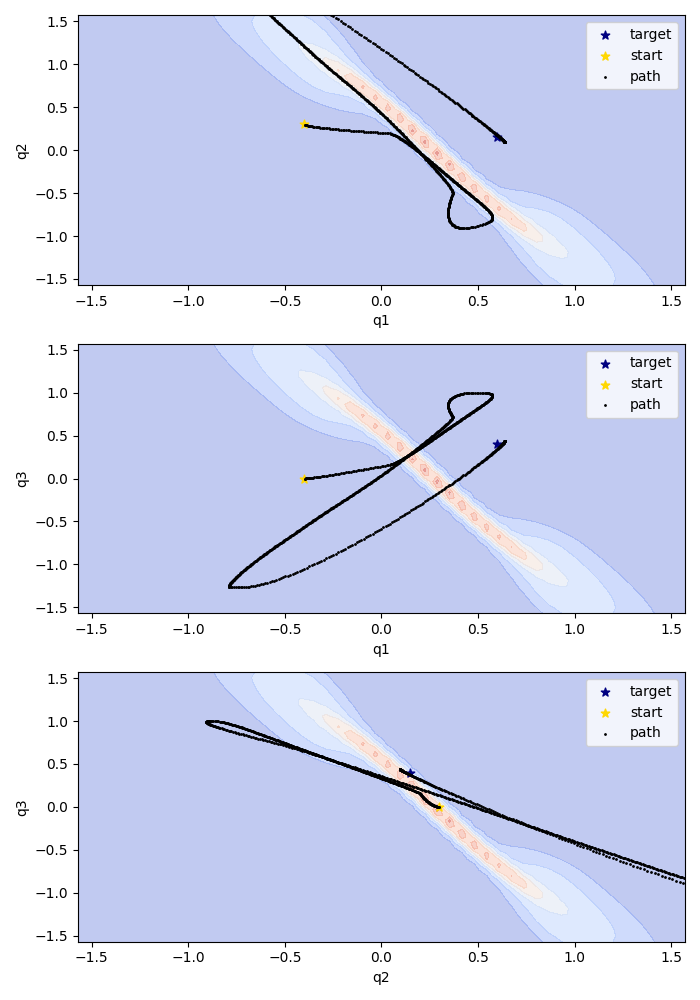

In [8]:
plot_coupled_embeddings(grid, config_attractor, ps, embedding=a, start=config_start)
plt.show()